## Is the car damaged?

In [1]:
!pip install -Uqq fastai

In 2015 the idea of creating a computer system that could recognise birds was considered so outrageously challenging that it was the basis of [this XKCD joke](https://xkcd.com/1425/):

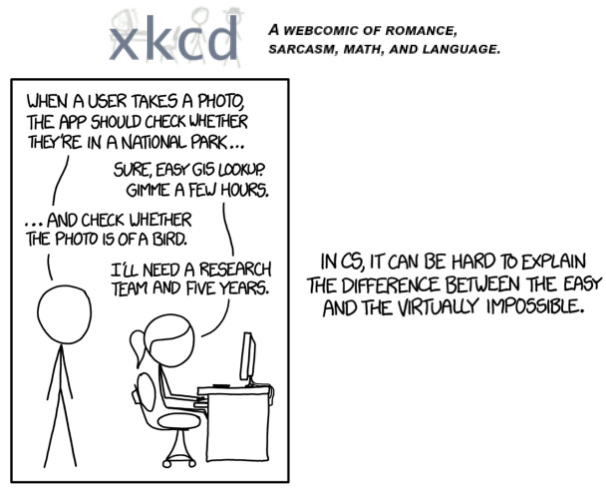

But today, we can do so much more than that, in just a few minutes, using entirely free resources!

The basic steps we'll take are:

1. Use DuckDuckGo to search for images of "car photos"
1. Use DuckDuckGo to search for images of "damaged car photos"
1. Fine-tune a pretrained neural network to recognise these two groups
1. Try running this model on a picture of a normal or damaged car and see if it works.

## Step 1: Download images of normal and damaged cars

In [2]:
from fastcore.all import *
import time

def search_images(term, max_images=200):
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    while len(urls)<max_images and 'next' in data:
        data = urljson(requestUrl,data=params)
        urls.update(L(data['results']).itemgot('image'))
        requestUrl = url + data['next']
        time.sleep(0.2)
    return L(urls)[:max_images]

Let's start by searching for a damaged car photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [3]:
urls = search_images('photo of a damaged car', max_images=1)
urls[0]

'https://i0.wp.com/joyfulsurroundingsllc.com/wp-content/uploads/2015/06/crumpled-car.jpg?ssl=1'

...and then download a URL and take a look at it:

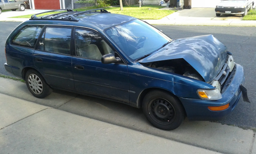

In [4]:
from fastdownload import download_url
dest = 'damaged-car.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

ouch!!

Now let's do the same with "photo of a car":

In [5]:
download_url(search_images('photo of a car', max_images=1)[0], 'car.jpg', show_progress=False)
Image.open('car.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab 200 examples of each of "photo of a car" and "photo of a damaged car" photos, and save each group of photos to a different folder:

In [6]:
searches = 'photo of a damaged car','photo of a car'
path = Path('car_damage')
# path = Path('data/car_damage')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    resize_images(path/o, max_size=400, dest=path/o)

In [7]:
print(path)

car_damage


## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

10

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

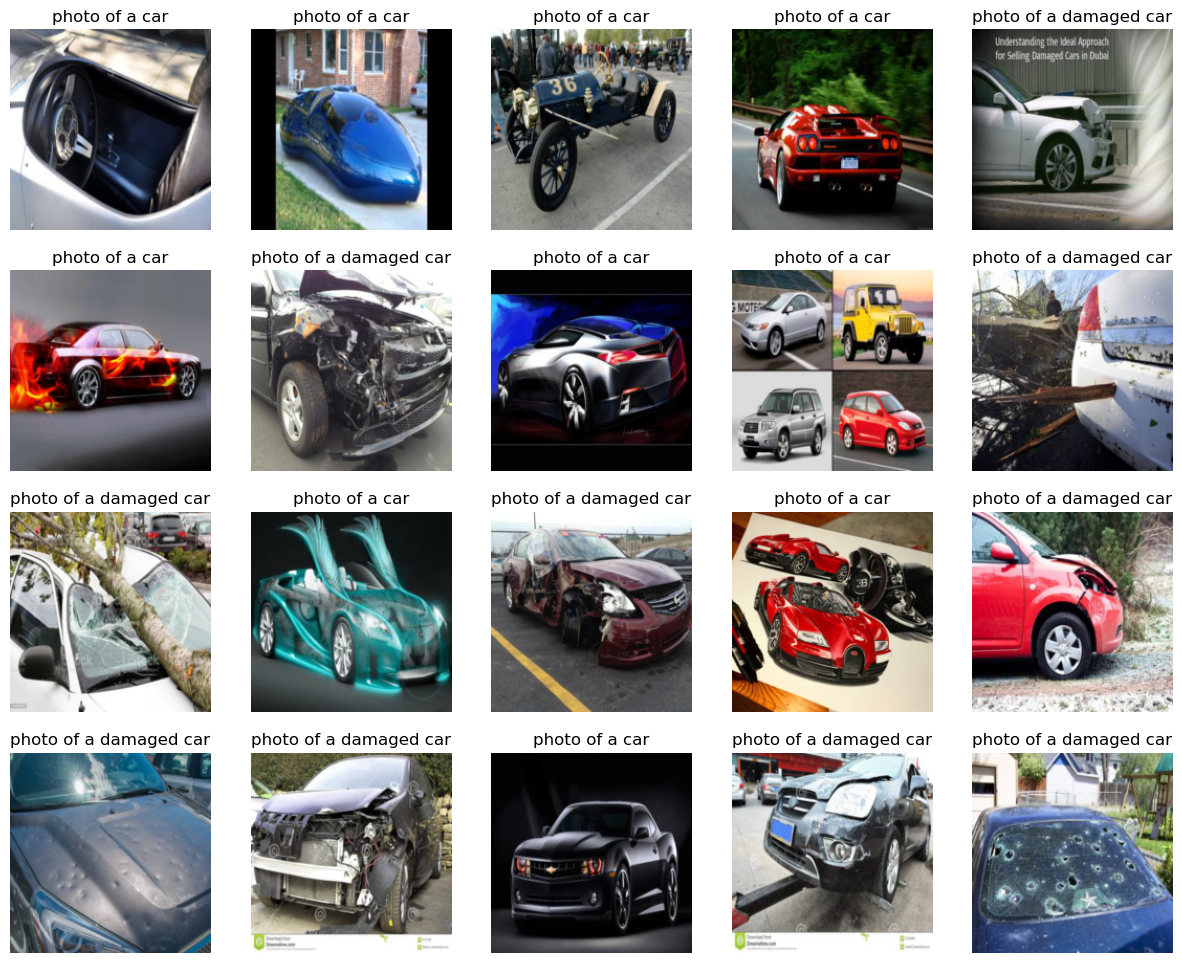

In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=20)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "normal car" or "damaged car").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *photo of a car* or *photo of a damaged car*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

Let's look at more of our downloaded photos

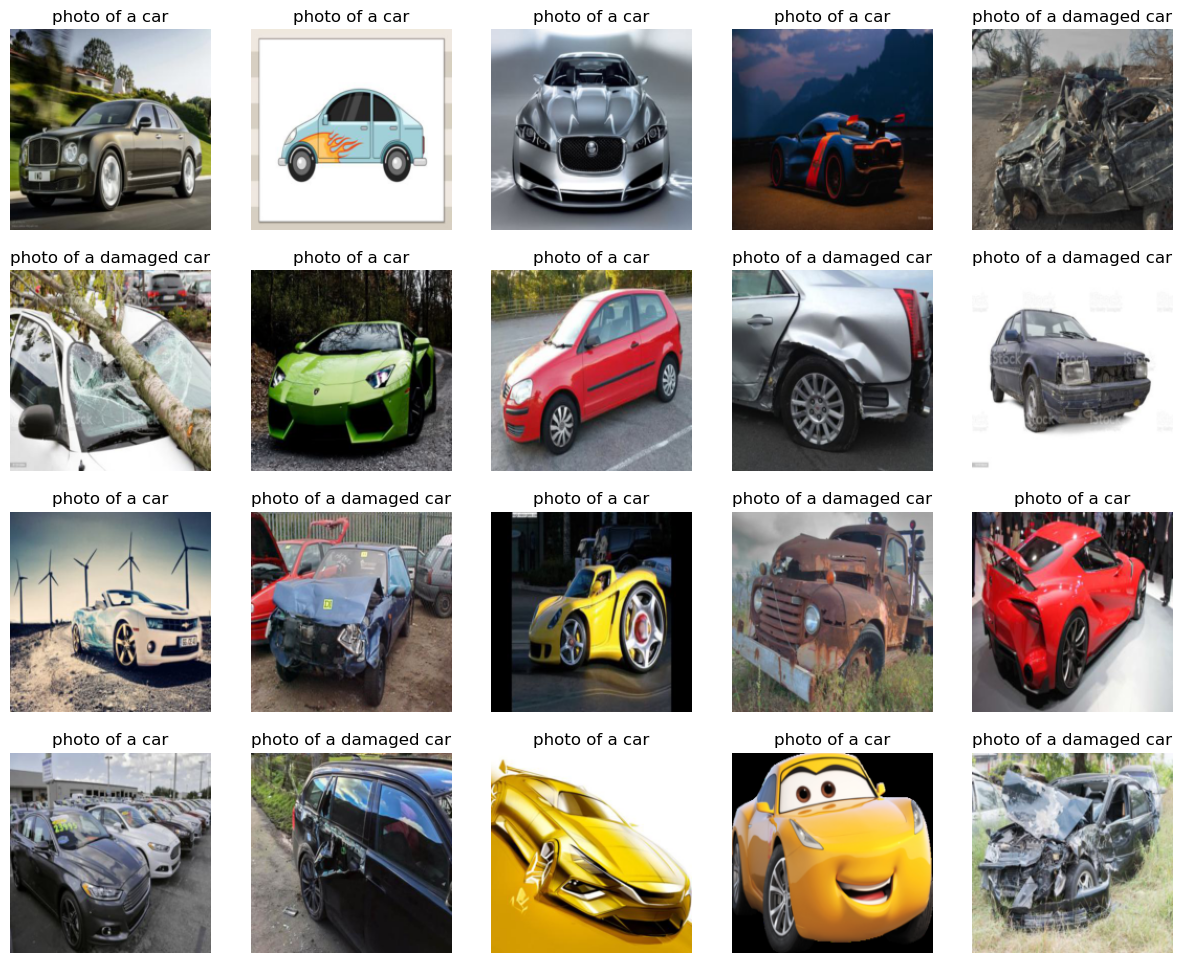

In [10]:
dls.show_batch(max_n=20)

In [11]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(30)

c:\ProgramData\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Not a fantastic error rate 10% but we have only performed a very quick check on training image quality.  

This is my first project with the [fast.ai course](https://course.fast.ai/) being hosted live at [The University of Queensland](https://itee.uq.edu.au/event/2022/practical-deep-learning-coders-uq-fastai) from April-June 2022.

## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that car we downloaded at the start:

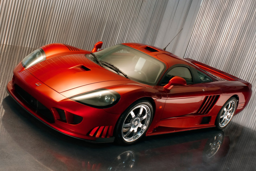

In [12]:
download_url(search_images('photo of a car', max_images=1)[0], 'car.jpg', show_progress=False)
Image.open('car.jpg').to_thumb(256,256)

In [13]:
is_normal,_,probs = learn.predict(PILImage.create('car.jpg'))
print(f"This is a: {is_normal}.")
print(f"Probability it's a normal car: {probs[0]:.4f}")

This is a: photo of a car.
Probability it's a normal car: 1.0000


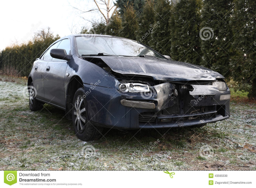

In [14]:
download_url(search_images('photo of a damaged car', max_images=1)[0], 'damaged-car.jpg', show_progress=False)
Image.open('damaged-car.jpg').to_thumb(256,256)

In [15]:
is_normal,_,probs = learn.predict(PILImage.create('damaged-car.jpg'))
print(f"This is a: {is_normal}.")
print(f"Probability it's a normal car: {probs[0]:.4f}")

This is a: photo of a damaged car.
Probability it's a normal car: 0.0000


Now it's your turn. Click "Copy & Edit" and try creating your own image classifier using your own image searches!

If you enjoyed this, please consider clicking the "upvote" button in the top-right -- it's very encouraging to us notebook authors to know when people appreciate our work.

Here is a link to Jeremy Howard's original [notebook](https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data) which was the source and inspiration of the code used in this notebook.